In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare input data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * 2 * math.pi) + torch.randn(train_x.size()) + math.sqrt(0.04)

#### GP Model

In [3]:
class MyGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Evaluation Settings

In [4]:
# fetch likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGPModel(train_x, train_y, likelihood)

# training loop
training_iter = 50
model.train()
likelihood.train()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# define the loss for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#### Training Iterations

In [5]:
# training iter
for i in range(training_iter):
    optimizer.zero_grad()

    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()

    print("Iter:{}/{}, loss:{}, length_scale:{}, noise:{}".format(
        i, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise_covar.noise.item()
    ))

    optimizer.step()

Iter:0/50, loss:1.7580726146697998, length_scale:0.6931471824645996, noise:0.6932471990585327
Iter:1/50, loss:1.7202266454696655, length_scale:0.6443966627120972, noise:0.7444967031478882
Iter:2/50, loss:1.6876503229141235, length_scale:0.5980837941169739, noise:0.7977122664451599
Iter:3/50, loss:1.6595709323883057, length_scale:0.5541679859161377, noise:0.8523622751235962
Iter:4/50, loss:1.6352736949920654, length_scale:0.5125977993011475, noise:0.9077761173248291
Iter:5/50, loss:1.6142361164093018, length_scale:0.4733077585697174, noise:0.9631553888320923
Iter:6/50, loss:1.5962579250335693, length_scale:0.43623363971710205, noise:1.0176101922988892
Iter:7/50, loss:1.5814628601074219, length_scale:0.4013529419898987, noise:1.0702247619628906
Iter:8/50, loss:1.5701483488082886, length_scale:0.36874261498451233, noise:1.120146632194519
Iter:9/50, loss:1.5625039339065552, length_scale:0.33861857652664185, noise:1.166669249534607
Iter:10/50, loss:1.558320164680481, length_scale:0.31130126

#### Evaluation Settings and Iterations

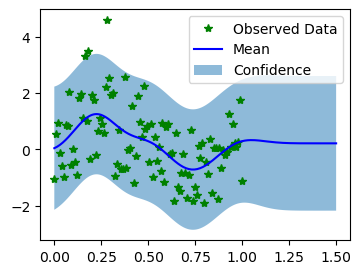

In [6]:
# evaluation step --> returns p(f* | x*, X, y)
# model(test_x) returns model distribution
# likelihood(model(test_x)) returns output distribution
model.eval()
likelihood.eval()

f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1.5, 202)
    observed_pred = likelihood(model(test_x))

    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'g*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    plt.show()

In [48]:
for param_name, param in model.named_parameters():
    print("Parameter name:{}, value:{}".format(param_name, param.item()))

Parameter name:likelihood.noise_covar.raw_noise, value:0.6728188395500183
Parameter name:mean_module.raw_constant, value:0.21384862065315247
Parameter name:covar_module.raw_outputscale, value:-0.8991109132766724
Parameter name:covar_module.base_kernel.raw_lengthscale, value:-2.0375816822052


In [9]:
raw_outputscale = model.covar_module.raw_outputscale

In [10]:
print("raw_outputscale is {}".format(raw_outputscale))

raw_outputscale is Parameter containing:
tensor(-0.8991, requires_grad=True)


In [11]:
for constraint_name, constraint in model.named_constraints():
    print("Constraint name:{}, constraint:{}".format(constraint_name, constraint))

Constraint name:likelihood.noise_covar.raw_noise_constraint, constraint:GreaterThan(1.000E-04)
Constraint name:covar_module.raw_outputscale_constraint, constraint:Positive()
Constraint name:covar_module.base_kernel.raw_lengthscale_constraint, constraint:Positive()


In [42]:
x = torch.randn(10, 5)
base_covar_module = gpytorch.kernels.RBFKernel()
scaled_covar_module = gpytorch.kernels.ScaleKernel(base_covar_module)
covar = scaled_covar_module(x)
print(x)

tensor([[-0.1414, -0.4146,  1.2880, -0.4308,  0.9671],
        [ 0.9822, -0.3704, -0.0510,  0.9286, -0.8754],
        [ 1.3505, -0.0313,  1.0573,  0.3942,  0.9988],
        [-1.6206,  0.2123,  0.5580,  1.0983,  0.1124],
        [ 1.7257,  0.7133, -0.1668, -1.3851, -0.6904],
        [ 0.2843,  1.6934, -0.1376,  0.5055, -0.6355],
        [-0.9485,  0.7310,  1.4164,  1.6628,  1.1907],
        [ 0.1994, -0.4833, -0.2857, -0.1763, -0.2728],
        [ 1.6399, -0.6418,  0.7077,  0.7111, -1.4634],
        [ 0.1724,  1.0986,  1.0084, -1.0193,  0.0788]])


In [43]:
s_orig = covar.numpy()
orig = base_covar_module(x).numpy()
print(s_orig[1][0]/orig[1][0])

0.6931472


In [46]:
print(scaled_covar_module.raw_outputscale)
constraint = scaled_covar_module.raw_outputscale_constraint

print('Transformed outputscale', constraint.transform(scaled_covar_module.raw_outputscale))
print('constraint', constraint)
print('Actual outputscale', scaled_covar_module.outputscale)

Parameter containing:
tensor(0., requires_grad=True)
Transformed outputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)
constraint Positive()
Actual outputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)


In [54]:
print(likelihood.noise_covar.raw_noise)
print(likelihood.noise)

Parameter containing:
tensor([0.6728], requires_grad=True)
tensor([1.0852], grad_fn=<AddBackward0>)
